<a href="https://colab.research.google.com/github/zy-f/la-income/blob/develop/Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/workshops/week3'
FOLDERNAME = 'acmlab/workshops/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/acmlab/workshops/project


In [2]:
%load_ext autoreload
%autoreload 2
!nvidia-smi

Sat Oct 31 01:05:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
from collections import defaultdict, namedtuple
import os

from tqdm import tqdm

from PIL import Image

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(229)

import pandas as pd

import util
import webmercator

**Part 1:** The first function you should write is `csv_to_data()`. This should take in a filename and returns a dictionary `data` from zipcode to average income.

In [4]:
def csv_to_data(filename):
    """Takes in a `filename` and returns a dictionary `data` from zipcode to average income.
    For a given row, the average income is computed as 
    
    row['A02650'] / row['N1']"""
    df = pd.read_csv(filename)

    data = {}
    for idx, row in df.iterrows():
        data[row['ZIPCODE']] = row['A02650'] / row['N1']
    return data

In [5]:
income_data_raw = csv_to_data('16zpallnoagi.csv')
print(len(income_data_raw))

29874


**Part 2:** you should write the `load_zip_latlon_info` function. This function should:

- Take in a filename representing a path to a latitude/longitude data file with the following columns of interest:
    - `zip`: the zipcode
    - `state`: the state of the zipcode
    - `latitude`, `longitude`: the latitude and longitude of the zipcode
- Keep only zipcodes that are in our `data` dictionary.
- Convert the latitude and longitude to `x, y` values. (The `webmercator.xy(lat, lon, z)` function may be helpful here.)
- Create a dictionary from zipcode to `(x, y)` tuples.

In [6]:
def load_zip_latlon_info(filename):
    """Takes in a `filename` and returns a dictionary from zipcode to (x, y)."""
    df = pd.read_csv(filename, sep=';')                     # the datafile is separated by semicolons for some reason
    df = df[df['state'] == 'CA']                            # will make your code more efficient to only work on CA
    zip_to_latlon = {}
    for idx, row in df.iterrows():                          # loop through the rows of the dataframe
        x, y = webmercator.xy(row['latitude'], row['longitude'], 14)
        if (2794 <= x <= 2839) and (6528 <= y <= 6572):     # only zip codes in the data set
             zip_to_latlon[row['zip']] = (x, y)         
    return zip_to_latlon

In [7]:
zip_to_latlon_raw = load_zip_latlon_info('ziplatlon.csv')
income_data = dict([kv for kv in income_data_raw.items() if kv[0] in zip_to_latlon_raw])        # Only keep zipcodes in the 
zip_to_latlon = {zip:zip_to_latlon_raw[zip] for zip in income_data}
print(len(income_data))
print(len(zip_to_latlon))

332
332


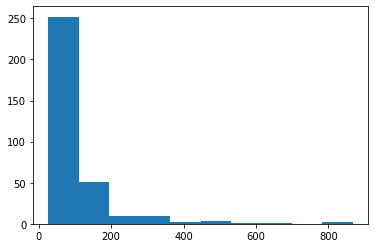

In [9]:
plt.hist(list(d for d in income_data.values()))
plt.show()

**Part 3:** Write a function `euclidean_distance` that takes in two (x, y) tuples and returns the **squared** Euclidean distance between the two points.

In [10]:
def euclidean_distance(pt1, pt2):
    x_dist = abs(pt2[0] - pt1[0])
    y_dist = abs(pt2[1] - pt1[1])
    return x_dist ** 2 + y_dist ** 2

**Part 4**: Write the dataset. The comments should be helpful in walking you through it.

For more understanding of how a dataset works, please consult the project handout.

Our implementation of the dataset takes about 6 minutes to finish running.  There are definitely more efficient ways to do it.

In [61]:
class ImageDataset(Dataset):
    def __init__(self, main_dir, transform, income_data, zip_to_latlon):
        self.main_dir = main_dir
        self.transform = transform
        self.zip_to_latlon = zip_to_latlon
        self.zip_to_income = income_data

        
        self.latlons = []
        self.total_imgs = []
        oceanic = 0

        skipped = 0 # remove

        # This loops through all the images in the directory.
        for filename in tqdm(sorted(os.listdir(main_dir))):             # tqdm lets you get a nice progress bar
            # Step 1: if the filename is not a .jpg, continue. 

            # Step 2: extract the x and y values out of the filename.
            # Remember that a filename is of the form: 14_2817_6565.jpg 
            # where x=2817, y=6565.
            
            # Step 3: check if the tile is oceanic (i.e. has elevation 0).
            # The util.getElevation function takes in a **latitude** and **longitude** and returns an elevation.
            # To get a latitude and longitude from a x and y, use `webmercator.latlon(x, y, z=14)`.
            # If it is, ignore it.
            
            # Step 4: Append (x, y) to the self.latlons list.

            if filename.endswith('.jpg') == False:
                skipped += 1 # remove
                continue

            coords = filename.strip('.jpg').split('_')
            zoom = int(coords[0])
            x = int(coords[1])
            y = int(coords[2])


            latlon = webmercator.latlon(x, y, zoom)
            lat = latlon[0]
            lon = latlon[1]
            elevation = util.getElevation(lat, lon)

            if elevation == oceanic:    #
                continue

            self.latlons.append((x, y))
  
            image = Image.open('images/' + filename).convert("RGB")
            self.total_imgs.append(image)


        self.zipcodes = []                                              # a list of zipcodes 
        self.tile_to_zipcode = {}
        # get the list of zip codes we need
        for zipcode, (zipcode_x, zipcode_y) in zip_to_latlon.items():   # loops through zipcodes and their x, y coordinates
            for x, y in self.latlons:                                   
                if self.in_tile((zipcode_x, zipcode_y), (x, y)):        # check if this zipcode is in the tile
                    self.zipcodes.append(zipcode)
                    self.tile_to_zipcode[(x, y)] = zipcode
        
        for idx, (x, y) in enumerate(self.latlons):
            if (x, y) not in self.tile_to_zipcode:                     # if this tile isn't already assigned
                # find the closest zipcode
                # you can use the `min(self.zipcodes, key=FUNCTION)` here
                best_zipcode = min(self.zipcodes, key=lambda k: euclidean_distance((self.zip_to_latlon[k]), (x, y)))           #
                self.tile_to_zipcode[(x, y)] = best_zipcode

        print(len(self.tile_to_zipcode), "entries.")
                
    def __len__(self):
        """Return the length of the dataset—how many images there are, total."""
        return len(self.total_imgs)
    
    def coordinates(self, zipcode):
        """Returns the coordinates of the given zipcode."""
        return self.zip_to_latlon[zipcode]     # 
    
    def in_tile(self, coord, square):
        """checks whether a given coordinate is in a tile"""
        lat, lon = coord
        llat, llon = square
        ulat, ulon = llat + 1, llon + 1
        return (lat >= llat and lon >= llon and lat <= ulat and lon <= ulon)
  
    def get_image(self, idx):
        """Returns the image at this index."""
        return self.total_imgs[idx]     # 

    def get_label(self, idx):
        """Given an index, return the ground truth label for that index."""
        zipcode = self.tile_to_zipcode[self.latlons[idx]]
        return np.float32(self.zip_to_income[zipcode])     #
    
    def __getitem__(self, idx):
        """Return the image and label at a given index"""
        tensor_image =  self.transform(self.get_image(idx))  # 
        label = self.get_label(idx) # 
        return tensor_image, label
    
    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

In [62]:
transform = ToTensor()
dset = ImageDataset('images', transform, income_data, zip_to_latlon)

100%|██████████| 1980/1980 [00:03<00:00, 584.32it/s]


1457 entries.


This code block creates train and validation dataloaders.

In [63]:
validation_split = 0.10
dataset_size = len(dset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [73]:
train_dataloader = DataLoader(dset, batch_size=16, sampler=train_sampler)
valid_dataloader = DataLoader(dset, batch_size=16, sampler=valid_sampler)

**Step 5**: Create the model.  Workshop 3 may be useful for this.
We suggest a series of convolutional layers interspersed with `torch.nn.MaxPool2d` layers, followed by a series of linear layers.
Each convolutional and linear layer should be followed by an activation function.

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBNRelu6(nn.Sequential):
    def __init__(self, in_, out, kernel, stride, padding=0, groups=1):
        super(ConvBNRelu6, self).__init__(
            nn.Conv2d(in_channels=in_, out_channels=out, kernel_size=kernel, stride=stride, padding=padding, groups=groups, bias=False),
            nn.BatchNorm2d(num_features=out),
            nn.ReLU6(inplace=True)
        )

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels=128, c=1, t=1, s=1):
        super(BottleneckBlock, self).__init__()
        tk = int(round(in_channels*t))
        self.use_res = (s==1) and (in_channels==c)
        layers = []
        if t != 1:
            layers.append(ConvBNRelu6(in_=in_channels, out=tk, kernel=(1,1), stride=(1,1)))
        layers += [
            ConvBNRelu6(in_=tk, out=tk, kernel=(3,3), stride=(s,s), padding=(1,1), groups=tk), #depthwise
            nn.Conv2d(in_channels=tk, out_channels=c, kernel_size=(1,1)),
            nn.BatchNorm2d(c)
        ]
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        if self.use_res:
            return x + self.conv(x)
        return self.conv(x)

# for debug
class PrintShape(nn.Module):
    def __init__(self):
        super(PrintShape, self).__init__()
    def forward(self, x):
        print(x.shape)
        return x

In [66]:
class Sequence(object):
  def __init__(self, **kwargs):
      for k,v in kwargs.items():
          setattr(self,k,v)

In [76]:
# implementing mobilenetv2: https://arxiv.org/pdf/1801.04381.pdf

class Model(torch.nn.Module):
    def __init__(self, input_dim=256, img_depth=3, sequence_list=[], dropout=.2, fc_hidden_dims=500):
        super(Model, self).__init__()
        layers = []
        inp_size = img_depth
        for seq in sequence_list:
          for i in range(seq.n):
            if i > 0 and seq.s > 1:
                seq.s = 1
            if seq.op == 'conv2d':
                layers.append(ConvBNRelu6(in_=inp_size, out=seq.c, kernel=seq.kernel, stride=seq.s, padding=seq.kernel//2))
            elif seq.op == 'bottleneck':
                layers.append(BottleneckBlock(in_channels=inp_size, c=seq.c, t=seq.t, s=seq.s))
            elif seq.op == 'avgpool':
                layers.append(nn.AvgPool2d(input_dim))
            inp_size = seq.c
            input_dim //= (input_dim if seq.s==-1 else seq.s)
        layers.append(nn.Flatten())
        self.features = nn.Sequential(*layers)
        self.regressor = nn.Sequential(
            nn.Linear(inp_size, fc_hidden_dims),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden_dims, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x


In [53]:
# "unit test"
# ORIGINAL PAPER SETTINGS
"""
sequence_list = [
    Sequence(op='conv2d', t=None, c=32, n=1, s=2, kernel=3),
    Sequence(op='bottleneck', t=1, c=16, n=1, s=1),
    Sequence(op='bottleneck', t=6, c=24, n=2, s=2),
    Sequence(op='bottleneck', t=6, c=32, n=3, s=2),
    Sequence(op='bottleneck', t=6, c=64, n=4, s=2),
    Sequence(op='bottleneck', t=6, c=96, n=3, s=1),
    Sequence(op='bottleneck', t=6, c=160, n=3, s=2),
    Sequence(op='bottleneck', t=6, c=320, n=1, s=1),
    Sequence(op='conv2d', t=None, c=1280, n=1, s=1, kernel=1),
    Sequence(op='avgpool', t=None, c=1280, n=1, s=-1), #input is now just a vertical stack 1x1x1280 -> linear time
]
"""

# for prebuilt model
# prebuilt = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
# print(prebuilt)

sequence_list = [
    Sequence(op='conv2d', t=None, c=32, n=1, s=2, kernel=3),
    Sequence(op='bottleneck', t=1, c=16, n=1, s=1),
    Sequence(op='bottleneck', t=6, c=24, n=1, s=2),
    Sequence(op='bottleneck', t=6, c=24, n=1, s=2),
    Sequence(op='bottleneck', t=6, c=32, n=1, s=2),
    Sequence(op='bottleneck', t=6, c=32, n=1, s=2),
    Sequence(op='bottleneck', t=6, c=64, n=1, s=2),
    Sequence(op='conv2d', t=None, c=160, n=1, s=1, kernel=1),
    Sequence(op='avgpool', t=None, c=160, n=1, s=-1), #input is now just a vertical stack 1x1x1280 -> linear time
]

fc_hidden_dims = 100

model = Model(input_dim=256, img_depth=3, sequence_list=sequence_list, fc_hidden_dims=fc_hidden_dims).cuda()
print(model)
# test_batch = torch.rand(8,3,256,256).cuda()
# out = model(test_batch)
# print(out)

!nvidia-smi

Model(
  (features): Sequential(
    (0): ConvBNRelu6(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): BottleneckBlock(
      (conv): Sequential(
        (0): ConvBNRelu6(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): BottleneckBlock(
      (conv): Sequential(
        (0): ConvBNRelu6(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running

**Step 6**: Train the model. Use `torch.nn.MSELoss(reduction='sum')` here, or one of the other losses specified in the project spec, since we're trying to output a real value (not categories). 

In [ ]:
# train loop
# model = Model(input_dim=256, img_depth=3, sequence_list=sequence_list, fc_hidden_dims=fc_hidden_dims)
# model = model.cuda()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

writer = SummaryWriter()

model.train()
num_epochs = 200
for epoch_num in range(num_epochs):
    avg_train_loss = 0
    avg_train_l1 = 0
    for i, (img_batch, label) in enumerate(train_dataloader):
        img_batch = img_batch.cuda()
        label = label.cuda()
        
        pred = model(img_batch).squeeze()
        loss = criterion(pred, label)
        # Step 1: feed your predictions into the model, outputting a variable `pred`
        # Step 2: calculate the loss w.r.t the predictions and the labels

        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 10)
        avg_train_loss += loss.item()
        avg_train_l1 += torch.abs(pred - label).sum()
        optimizer.step()

    avg_train_loss /= len(train_indices)
    avg_train_l1 /= len(train_indices)
    print(f'Epoch {epoch_num+1} -> Train loss: {avg_train_loss}    Train L1: {avg_train_l1}')

    with torch.no_grad():
        model.eval()
        avg_val_loss = 0
        avg_val_l1 = 0
        for i, (img_batch, label) in enumerate(valid_dataloader):
            img_batch = img_batch.cuda()
            label = label.cuda()

            pred = model(img_batch).squeeze()
            loss = criterion(pred, label)
            # Step 1: feed your predictions into the model, outputting a variable `pred`
            # Step 2: calculate the loss w.r.t the predictions and the labels


            avg_val_loss += loss
            avg_val_l1 += torch.abs(pred - label).sum()
        avg_val_loss /= len(val_indices)
        avg_val_l1 /= len(val_indices)
        print(f'Eval -> Loss: {avg_val_loss}    L1: {avg_val_l1}')
        
    # print(epoch_num, float(avg_train_loss), float(avg_val_loss), float(avg_train_l1), float(avg_val_l1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 1 -> Train loss: 4818.410241103754    Train L1: 42.77333450317383
Eval -> Loss: 4992.8515625    L1: 45.638912200927734


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2 -> Train loss: 4554.595472382336    Train L1: 39.37619400024414
Eval -> Loss: 4877.4716796875    L1: 41.854740142822266
Epoch 3 -> Train loss: 3230.451655690263    Train L1: 34.4557991027832
Eval -> Loss: 5550.86572265625    L1: 44.017913818359375
Epoch 4 -> Train loss: 2277.377546729111    Train L1: 30.159591674804688
Eval -> Loss: 6141.96337890625    L1: 44.58848571777344
Epoch 5 -> Train loss: 2475.231093988186    Train L1: 29.61995506286621
Eval -> Loss: 5576.689453125    L1: 43.66187286376953
Epoch 6 -> Train loss: 2096.8837697098893    Train L1: 28.216550827026367
Eval -> Loss: 4867.5537109375    L1: 45.43216323852539
Epoch 7 -> Train loss: 2461.418784164801    Train L1: 30.5201473236084
Eval -> Loss: 5781.47412109375    L1: 45.671512603759766
Epoch 8 -> Train loss: 1829.3173474567693    Train L1: 27.547924041748047
Eval -> Loss: 5863.00830078125    L1: 44.36265182495117
Epoch 9 -> Train loss: 1950.9511409852562    Train L1: 28.50865936279297
Eval -> Loss: 5717.4013671875

In [ ]:
for i in [700, 3, 52, 611, 458, 299]:
    display(dset.total_imgs[i])
    print(dset[i][1])
    print(model(dset[i][0].unsqueeze(0).cuda()))